In [25]:
#モジュールをインポート
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold

In [26]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
train = pd.read_csv("/content/drive/My Drive/Python/SIGNATE/bike/cleaning_train.csv")
test = pd.read_csv("/content/drive/My Drive/Python/SIGNATE/bike/cleaning_test.csv")

# **前処理**

In [28]:
#lightGBMは、文字列型をカテゴリー変数に変更
for columns in train.select_dtypes(include = ["object"]).columns:
  train[columns] = train[columns].astype("category")

for columns in test.select_dtypes(include = ["object"]).columns:
  test[columns] = test[columns].astype("category")

In [29]:
X = train.drop(columns = ["bikes_available", "id"])
Y = train["bikes_available"]
X_test = test.drop(columns = "id")

# **cityの詳細**

In [30]:
station = pd.read_csv("/content/drive/My Drive/Python/SIGNATE/bike/station.csv")

<Axes: xlabel='city', ylabel='count'>

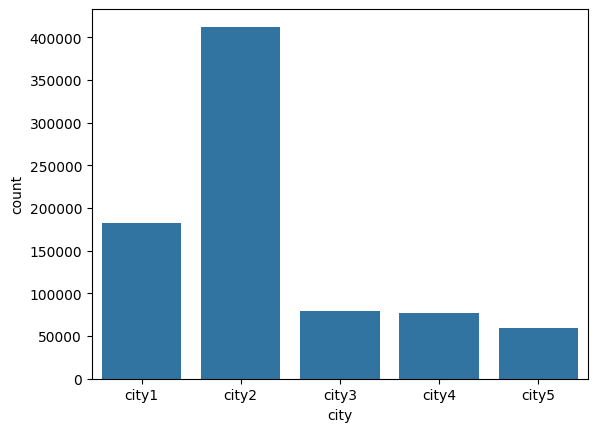

In [31]:
#各cityのデータ数を取得
sns.countplot(data = train, x = "city")

<Axes: xlabel='long', ylabel='lat'>

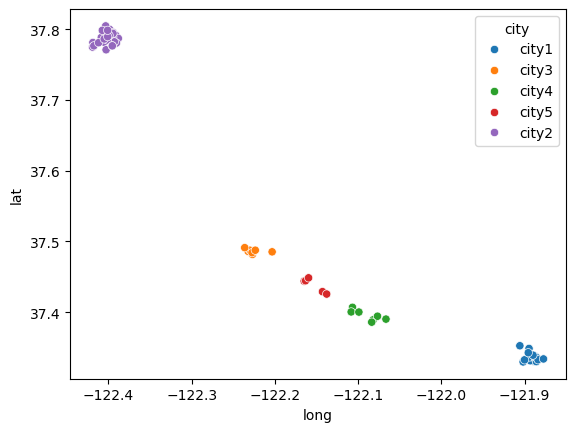

In [32]:
#緯度・経度の位置関係を表示
sns.scatterplot(data = station, x = "long", y = "lat", hue = "city", color = "coolwarm")

# **city1, city2, それ以外に分けてlightGBMで学習**

In [33]:
#文字列型をカテゴリー型に変形
for columns in train.select_dtypes(include = ["object"]).columns:
  train[columns] = train[columns].astype("category")

for columns in test.select_dtypes(include = ["object"]).columns:
  test[columns] = test[columns].astype("category")

In [34]:
train_city1 = train[train["city"] == "city1"]
test_city1 = test[test["city"] == "city1"]

train_city2 = train[train["city"] == "city2"]
test_city2 = test[test["city"] == "city2"]

train_other = train[train["city"].isin(["city3", "city4", "city5"])]
test_other = test[test["city"].isin(["city3", "city4", "city5"])]

## **前処理**

In [35]:
X_city1 = train_city1.drop(columns = ["bikes_available", "id"])
Y_city1 = train_city1["bikes_available"]
X_test_city1 = test_city1.drop(columns = "id")

X_city2 = train_city2.drop(columns = ["bikes_available", "id"])
Y_city2 = train_city2["bikes_available"]
X_test_city2 = test_city2.drop(columns = "id")

X_other = train_other.drop(columns = ["bikes_available", "id"])
Y_other = train_other["bikes_available"]
X_test_other = test_other.drop(columns = "id")

## **学習**

In [36]:
#KFoldで、複数回学習させて精度を高める
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

#y_predを保持する配列
y_pred_city1 = np.zeros(len(X_test_city1))
y_pred_city2 = np.zeros(len(X_test_city2))
y_pred_other = np.zeros(len(X_test_other))

param = {
  'objective': 'regression',
  'metric': 'rmse',
  'learning_rate': 0.05,
  'num_leaves': 20,
  'max_depth': 6,
  'min_data_in_leaf': 20,
  'lambda_l1': 0.1,
  'lambda_l2': 0.1,
  'feature_fraction': 0.8,
  'bagging_fraction': 0.8,
  'bagging_freq': 5,
  'verbose': -1
}

#city1用のモデル学習
for train_idx, val_idx in kf.split(X_city1):
  X_train_c1, X_val_c1 = X_city1.iloc[train_idx], X_city1.iloc[val_idx]
  Y_train_c1, Y_val_c1 = Y_city1.iloc[train_idx], Y_city1.iloc[val_idx]

  train_data_c1 = lgb.Dataset(X_train_c1, label = Y_train_c1)
  val_data_c1 = lgb.Dataset(X_val_c1, label = Y_val_c1)

  model_city1 = lgb.train(param, train_data_c1, valid_sets = [val_data_c1], num_boost_round = 100)

  y_pred_city1 += model_city1.predict(X_test_city1) / kf.n_splits

#city2用のモデル学習
for train_idx, val_idx in kf.split(X_city2):
  X_train_c2, X_val_c2 = X_city2.iloc[train_idx], X_city2.iloc[val_idx]
  Y_train_c2, Y_val_c2 = Y_city2.iloc[train_idx], Y_city2.iloc[val_idx]

  train_data_c2 = lgb.Dataset(X_train_c2, label = Y_train_c2)
  val_data_c2 = lgb.Dataset(X_val_c2, label = Y_val_c2)

  model_city2 = lgb.train(param, train_data_c2, valid_sets = [val_data_c2], num_boost_round = 100)

  y_pred_city2 += model_city2.predict(X_test_city2) / kf.n_splits

#city1, city2以外用のモデル学習
for train_idx, val_idx in kf.split(X_other):
  X_train_c1, X_val_c1 = X_other.iloc[train_idx], X_other.iloc[val_idx]
  Y_train_c1, Y_val_c1 = Y_other.iloc[train_idx], Y_other.iloc[val_idx]

  train_data_c1 = lgb.Dataset(X_train_c1, label = Y_train_c1)
  val_data_c1 = lgb.Dataset(X_val_c1, label = Y_val_c1)

  model_other = lgb.train(param, train_data_c1, valid_sets = [val_data_c1], num_boost_round = 100)

  y_pred_other += model_other.predict(X_test_other) / kf.n_splits

#各ポートの最大駐輪可能数を考慮して、予測値を修正
y_pred_city1 = np.minimum(y_pred_city1, X_test_city1["dock_count"].values)
y_pred_city2 = np.minimum(y_pred_city2, X_test_city2["dock_count"].values)
y_pred_other = np.minimum(y_pred_other, X_test_other["dock_count"].values)

#整数化
y_pred_city1 = np.round(y_pred_city1).astype(int)
y_pred_city2 = np.round(y_pred_city2).astype(int)
y_pred_other = np.round(y_pred_other).astype(int)

In [37]:
#idと予測値を合わせたデータフレームを作成
y_city1 = pd.DataFrame({"id": test_city1["id"], "y_pred": y_pred_city1})
y_city2 = pd.DataFrame({"id": test_city2["id"], "y_pred": y_pred_city2})
y_other = pd.DataFrame({"id": test_other["id"], "y_pred": y_pred_other})

#結合
y = pd.concat([y_city1, y_city2, y_other]).sort_values(by = "id")

y_sorted = test[["id"]].merge(y, on = "id", how = "left")
y_sorted = y_sorted.rename(columns = {"y_pred": "bikes_available"})

In [38]:
y_sorted.head()

,id,bikes_available
0,8761,13
1,8762,13
2,8763,13
3,8764,13
4,8765,13


<ipython-input-39-19b773fa1cda>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Importance', y = 'Feature', data = importance_df, palette = 'viridis')


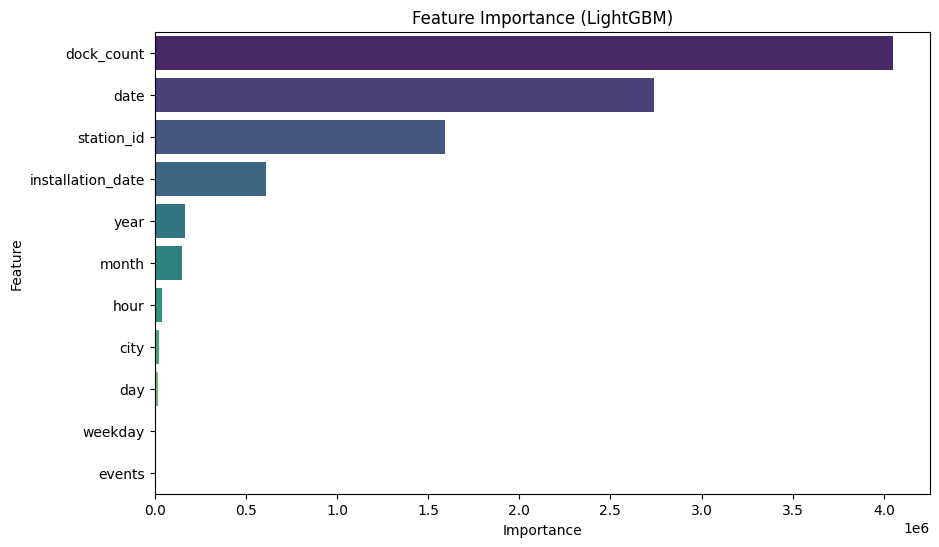

In [39]:
#特徴量重要度を取得
feature_importance = model_other.feature_importance(importance_type = 'gain')
feature_names = X.columns

#データフレーム化してソート
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

#グラフの作成
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = importance_df, palette = 'viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.show()

In [40]:
#csvに保存
submission = pd.DataFrame({"id": y_sorted["id"], "y_pred": y_sorted["bikes_available"]})

submission.to_csv("/content/drive/My Drive/Python/SIGNATE/bike/submission.csv", index = False, header = False)